
## ORIGINAL DATA SOURCE:

* The dataset contains 2 folders - Infected - Uninfected

* And a total of 27,558 images.

* This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 


In [45]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , Flatten ,Dropout
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report ,confusion_matrix

In [3]:
main_file_dir = '/content/drive/MyDrive/Colab Notebooks/CNN/cell_images/cell_images'

In [4]:
os.listdir(main_file_dir)

['train', 'test']

In [5]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/CNN/cell_images/cell_images/test'
train_dir = '/content/drive/MyDrive/Colab Notebooks/CNN/cell_images/cell_images/train'

os.listdir(train_dir)

['parasitized', 'uninfected']

In [116]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/CNN/cell_images/cell_images/train/parasitized')[0]


'C91P52ThinF_IMG_20150821_124937_cell_208.png'

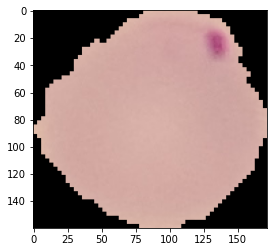

In [118]:
img_sample ='/content/drive/MyDrive/Colab Notebooks/CNN/cell_images/cell_images/train/parasitized/C91P52ThinF_IMG_20150821_124937_cell_208.png'
img_arr = imread(img_sample)
plt.imshow(img_arr)

In [8]:
img_arr.shape

(151, 154, 3)

In [9]:
len(os.listdir(train_dir+'/uninfected'))

12479

In [10]:
len(os.listdir(train_dir+'/parasitized'))

12479

In [49]:
# find out the average dimensions of these images

dim1=[]
dim2=[]

for img_filename in os.listdir(train_dir+'/parasitized'):

  img = imread(train_dir+'/parasitized' + '/' + img_filename)
  d1,d2,color = img.shape
  dim1.append(d1)
  dim2.append(d2)


In [50]:
np.mean(dim1) 


134.360205144643

In [51]:
np.mean(dim2)

133.66447632021797

In [12]:
img_shape = (130,130,3)

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

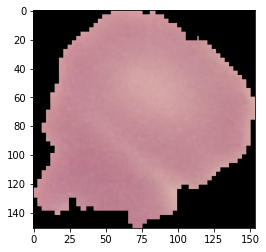

In [14]:
plt.imshow(img_arr)

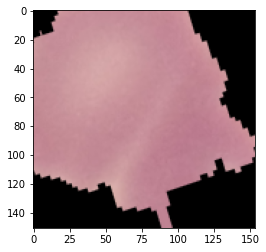

In [15]:
plt.imshow(image_gen.random_transform(img_arr))

In [16]:
#Generating many manipulated images from a directory
train = image_gen.flow_from_directory(train_dir,
                                      target_size=img_shape[:2],
                                      color_mode='rgb',
                                      batch_size=16,
                                      class_mode='binary')

Found 24958 images belonging to 2 classes.


In [17]:

test = image_gen.flow_from_directory(test_dir,
                                      target_size=img_shape[:2],
                                      color_mode='rgb',
                                      batch_size=16,
                                      class_mode='binary',
                                     shuffle=False)

Found 2600 images belonging to 2 classes.


In [18]:
train.class_indices

{'parasitized': 0, 'uninfected': 1}

In [96]:
#creating the model 

model = Sequential()

model.add(Conv2D(filters=32 , kernel_size=(3,3) , input_shape=img_shape , activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64 , kernel_size=(3,3) , input_shape=img_shape , activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64 , kernel_size=(3,3) , input_shape=img_shape , activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)            

In [98]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
%%time
model.fit(train , epochs=20  , callbacks=[early_stop] , validation_data=test )

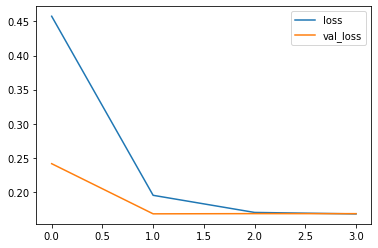

In [101]:



loss = pd.DataFrame(model.history.history)
loss[['loss','val_loss']].plot()

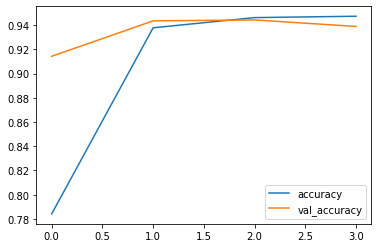

In [102]:

loss[['accuracy','val_accuracy']].plot()

In [103]:

model.evaluate_generator(test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.15992368757724762, 0.9438461661338806]

In [ ]:

# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict(test)

In [ ]:
pred_probabilities

In [104]:
predictions = pred_probabilities > 0.5

In [ ]:
# Numpy can treat this as True/False for us
predictions

In [105]:

print(classification_report(test.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1300
           1       0.93      0.95      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



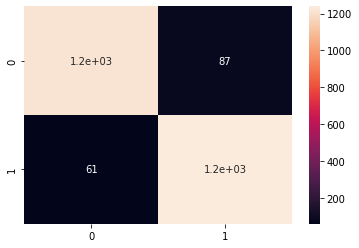

In [106]:
sns.heatmap(confusion_matrix(test.classes,predictions) , annot=True)

In [107]:
confusion_matrix(test.classes,predictions)


array([[1213,   87],
       [  61, 1239]])

In [123]:
#parasitized image 
para_image = image.load_img(img_sample , target_size=img_shape)

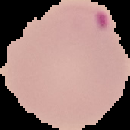

In [124]:
para_image

In [125]:





para_image = image.img_to_array(para_image)

In [126]:
para_image.shape

(130, 130, 3)

In [127]:
para_image = np.expand_dims(para_image,axis=0)

In [128]:

para_image.shape

(1, 130, 130, 3)

In [130]:
model.predict(para_image)

array([[0.]], dtype=float32)

In [131]:
train.class_indices

{'parasitized': 0, 'uninfected': 1}